In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
aisles_df = pd.read_csv(r"C:\Users\disha\OneDrive\Desktop\InstaCart\archive (2)\aisles.csv")
departments_df = pd.read_csv(r"C:\Users\disha\OneDrive\Desktop\InstaCart\archive (2)\departments.csv")
order_products_prior_df = pd.read_csv(r"C:\Users\disha\OneDrive\Desktop\InstaCart\archive (2)\order_products__prior.csv")
order_products_train_df = pd.read_csv(r"C:\Users\disha\OneDrive\Desktop\InstaCart\archive (2)\order_products__train.csv")
orders_df = pd.read_csv(r"C:\Users\disha\OneDrive\Desktop\InstaCart\archive (2)\orders.csv")
products_df = pd.read_csv(r"C:\Users\disha\OneDrive\Desktop\InstaCart\archive (2)\products.csv")

In [4]:
# checking the original orders_df before any joins
# 0.0 or NaN typically represents the first order
new_customers = orders_df[orders_df['order_number'] == 1].shape[0]
repeat_orders = orders_df[orders_df['order_number'] > 1].shape[0]

print(f"First Orders: {new_customers}")
print(f"Repeat Orders: {repeat_orders}")

First Orders: 206209
Repeat Orders: 3214874


In [5]:
# 1. Creating a Master Catalog (Inner join as products must have aisles/depts)
df_catalog = pd.merge(products_df, aisles_df, on='aisle_id', how='inner')
df_catalog = pd.merge(df_catalog, departments_df, on='department_id', how='inner')

# 2. Using LEFT joins for transactions to keep all order context
df_transactions = pd.merge(order_products_prior_df, df_catalog, on='product_id', how='left')

# 3. Joining with Orders - Using LEFT join to keep customers with only 1 order
df_final = pd.merge(df_transactions, orders_df, on='order_id', how='left') 

In [6]:
df_final.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [7]:
df_final.isna().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
dtype: int64

In [46]:
# Flagging NaNs as -1 to represent 'First Time Shoppers'
df_final['days_since_prior_order'] = df_final['days_since_prior_order'].fillna(-1)

In [47]:
df_final.isna().sum()

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

In [51]:
df_final.shape

(32434489, 15)

In [ ]:
# checking the original orders_df after joins for validation
# 0.0 or NaN typically represents the first order which is now flagged as -1
new_customers = orders_df[orders_df['order_number'] == 1].shape[0]
repeat_orders = orders_df[orders_df['order_number'] > 1].shape[0]

print(f"First Orders: {new_customers}")
print(f"Repeat Orders: {repeat_orders}")

First Orders: 206209
Repeat Orders: 3214874


In [ ]:
# Checking if the merge in Step 2 worked i.e orphan checking
missing_names = df_final['product_name'].isnull().sum()
print(f"Transactions missing a product name: {missing_names}")

Transactions missing a product name: 0


C:\Users\disha\AppData\Local\Temp\ipykernel_7212\771695531.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_depts.values, y=top_depts.index, palette='viridis')


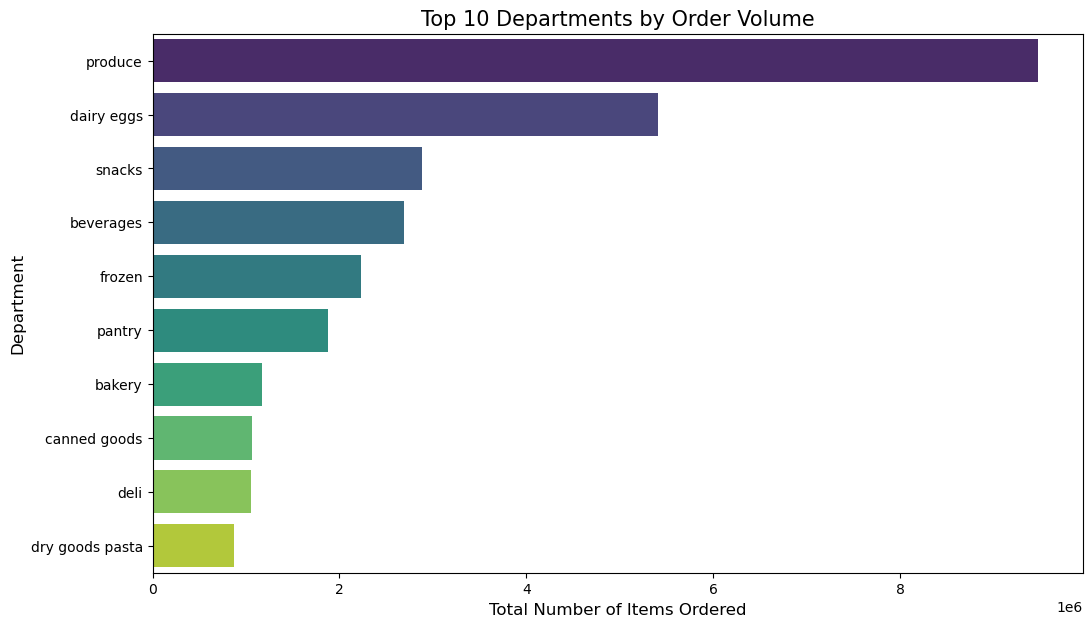

In [ ]:
# Counting the occurrences of each department
top_depts = df_final['department'].value_counts().head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_depts.values, y=top_depts.index, palette='viridis')

plt.title('Top 10 Departments by Order Volume', fontsize=15)
plt.xlabel('Total Number of Items Ordered', fontsize=12)
plt.ylabel('Department', fontsize=12)
plt.show()

C:\Users\disha\AppData\Local\Temp\ipykernel_28392\1580676380.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='crest')


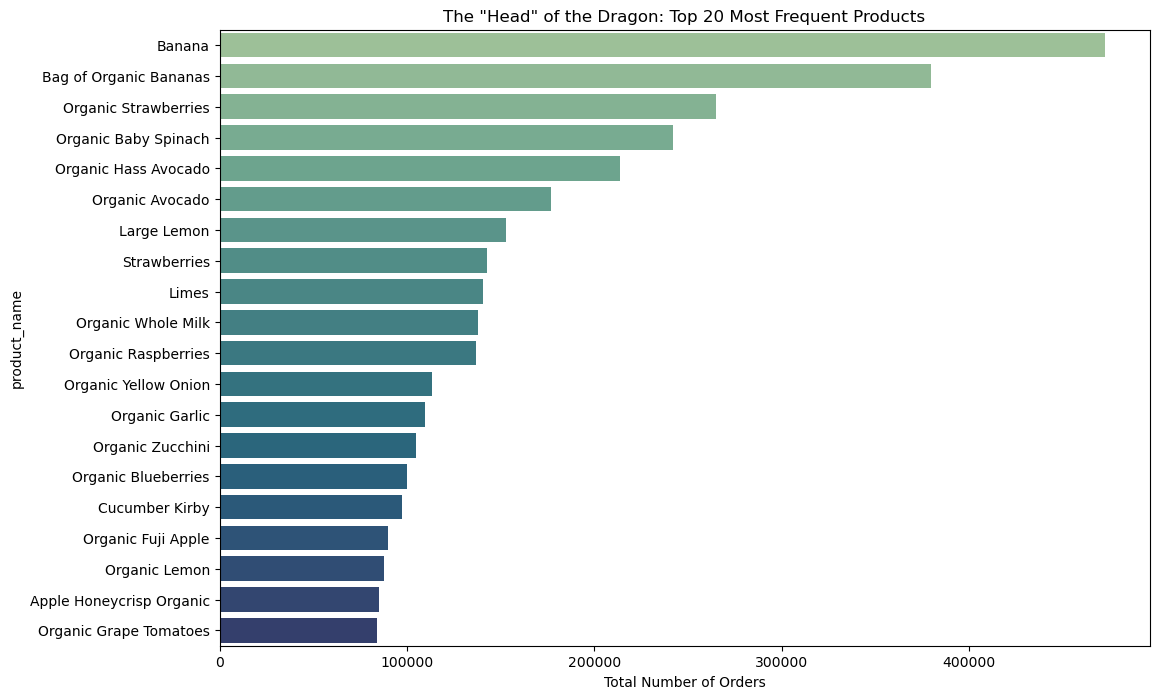

In [ ]:
# Getting top 20 products
top_products = df_final['product_name'].value_counts().head(20)

plt.figure(figsize=(12,8))
sns.barplot(x=top_products.values, y=top_products.index, palette='crest')
plt.title('The "Head" of the Dragon: Top 20 Most Frequent Products')
plt.xlabel('Total Number of Orders')
plt.show()

#### Identified that produce staples like Bananas dominate the volume. However, we can try to make our UP-Tree focus on finding the 'hidden gems' in the long tail that have higher profit margins than these common items.

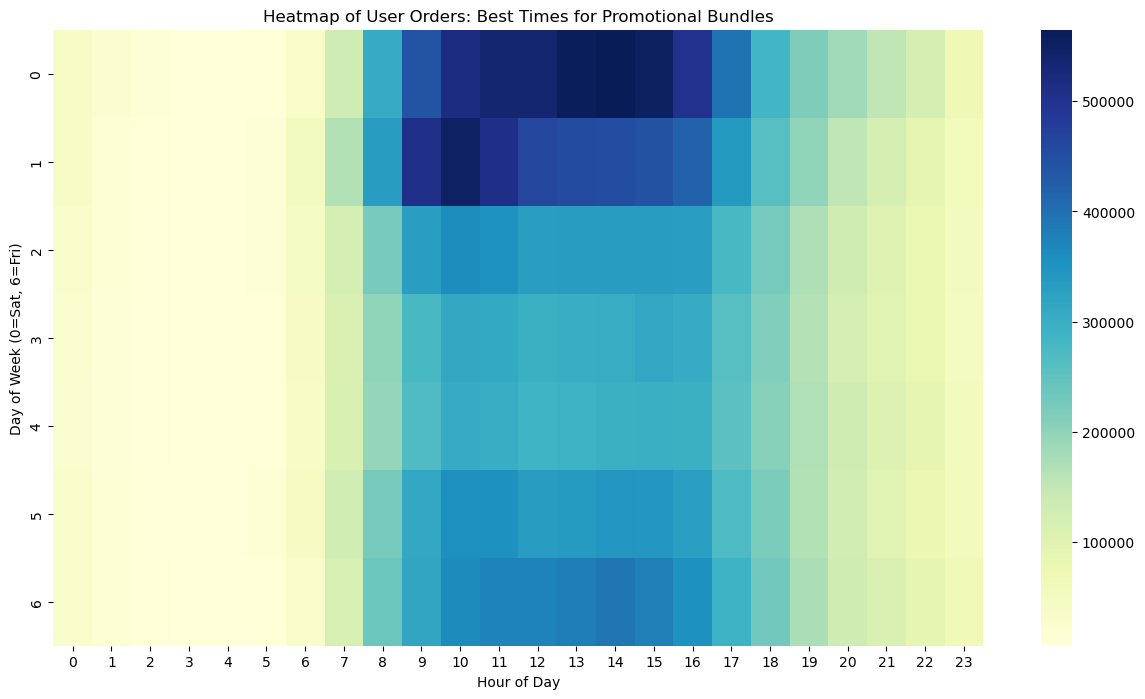

In [ ]:
# Creating a pivot table for the heatmap
heatmap_data = df_final.groupby(['order_dow', 'order_hour_of_day']).size().unstack()

plt.figure(figsize=(15,8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False)
plt.title('Heatmap of User Orders: Best Times for Promotional Bundles')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Sat, 6=Fri)')
plt.show()

#### The dark spots show our peak traffic. We can use this to suggest 'Dynamic Bundling' i.e changing the suggested items in the web app based on the time of day.

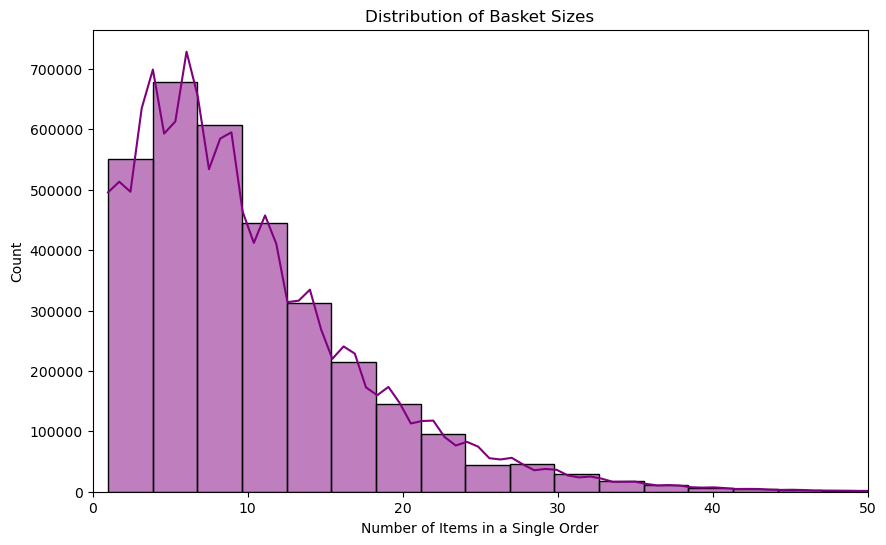

In [ ]:
# Grouping by order_id to get the size of each basket
basket_sizes = df_final.groupby('order_id')['product_id'].count()

plt.figure(figsize=(10,6))
sns.histplot(basket_sizes, bins=50, kde=True, color='purple')
plt.xlim(0, 50) # Limiting to 50 for better visibility
plt.title('Distribution of Basket Sizes')
plt.xlabel('Number of Items in a Single Order')
plt.show()

#### Most customers buy <=10 items. This means our recommendation engine should focus on small, high-impact bundles rather than trying to suggest 20 different products.

C:\Users\disha\AppData\Local\Temp\ipykernel_28392\1809581703.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dept_reorder.values, y=dept_reorder.index, palette='magma')


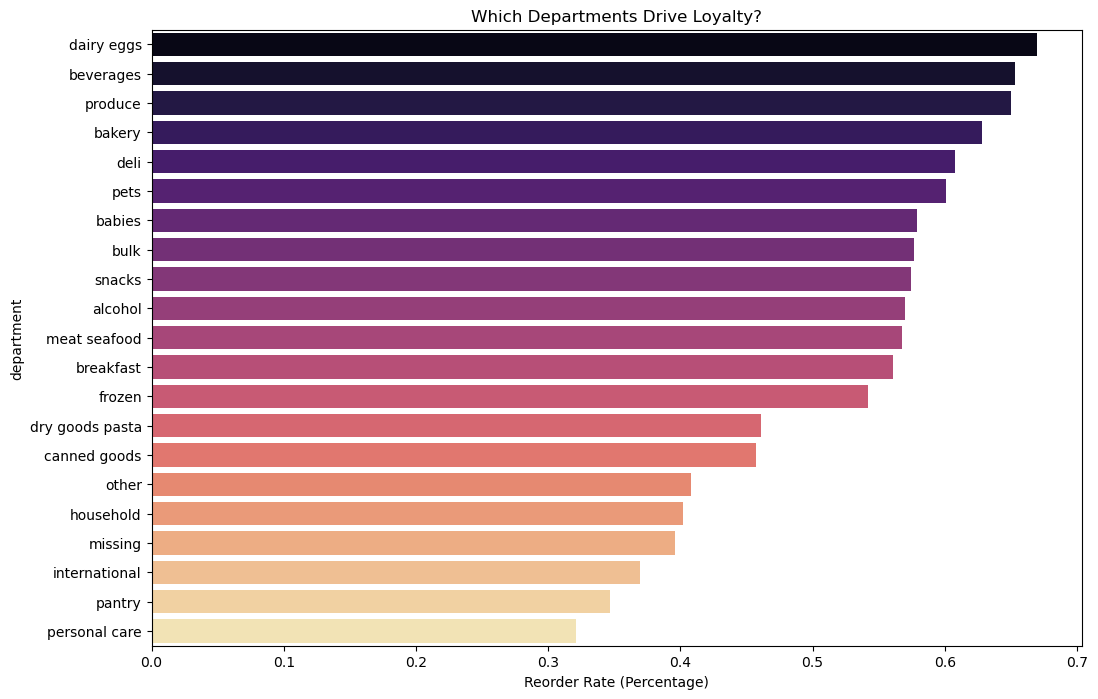

In [ ]:
# Calculating reorder ratio per department
dept_reorder = df_final.groupby('department')['reordered'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x=dept_reorder.values, y=dept_reorder.index, palette='magma')
plt.title('Which Departments Drive Loyalty?')
plt.xlabel('Reorder Rate (Percentage)')
plt.show()

#### Departments like Dairy, Beverages and Produce have the highest reorder rates. We will use these as 'Anchor Products' to pull customers toward lower-frequency, higher-margin categories.